# Forecasting of daily River Discharge (RD) based on temperature and previous precipitation levels

### Import of libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from sklearn import linear_model,preprocessing
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split


### LoadingData

In [18]:
data=pd.read_csv("RD_data/RD_AntuaR_pg.csv").values
diasBefore = 2
Xbefore = data[:,2:4]
second_colum = Xbefore[:,1]
second_colum = np.roll(second_colum,diasBefore)
new_column = np.expand_dims(second_colum, axis=1)
Xbefore = np.hstack((Xbefore, new_column))
X = Xbefore[diasBefore:,:]
print(X)

y = data[diasBefore:,1]

print(X.shape)

[[8.1 0.0 0.0]
 [8.1 7.9 0.0]
 [8.1 38.1 0.0]
 ...
 [10.4 21.4 0.0]
 [10.4 0.0 0.0]
 [10.4 0.0 21.4]]
(1579, 3)


### Prep of Data

In [19]:
def apply_boxcox(y, lambda_val=0):
    y_float64 = np.array(y, dtype=np.float64)
    if lambda_val == 0:
        res = boxcox(y_float64)
    else:
        res = boxcox(y_float64, lambda_val)
    y = res[0]
    lambda_val = res[1]
    return y, lambda_val

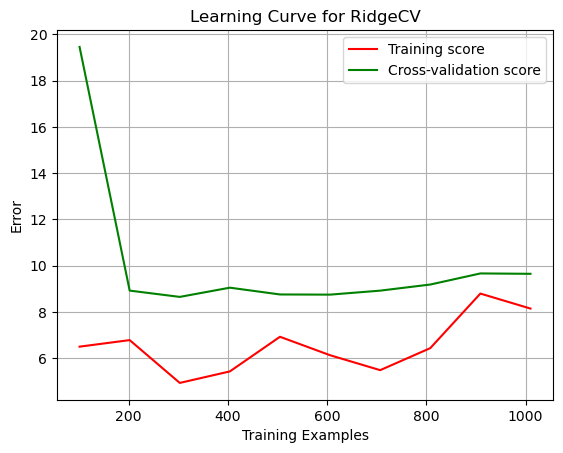

In [20]:
scaler = preprocessing.StandardScaler()
poly_features = preprocessing.PolynomialFeatures(degree=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
y_train_boxcox, lambda_val = apply_boxcox(y_train)

X_test_scaled = scaler.transform(X_test_poly)
y_test_boxcox, _ = apply_boxcox(y_test, lambda_val)

# Define a range of alpha values to test
alphas = [0.01,0.1,1,10,100]


ridge_cv = linear_model.RidgeCV(alphas=alphas)

# Create learning curve
train_sizes, train_errors, valid_errors = learning_curve(
    ridge_cv, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),scoring=lambda estimator, X, y: mean_squared_error(y, estimator.predict(X)))

# Calculate mean and standard deviation of training and validation errors
train_errors_mean = np.mean(train_errors, axis=1)
train_errors_std = np.std(train_errors, axis=1)
valid_errors_mean = np.mean(valid_errors, axis=1)
valid_errors_std = np.std(valid_errors, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve for RidgeCV")
plt.xlabel("Training Examples")
plt.ylabel("Error")

plt.grid()

plt.plot(train_sizes, train_errors_mean, '-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_errors_mean, '-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

### Cost Function

R-squared (R2): -0.4994785573308307
MSE: 4.542223461161521
RMSE: 2.131249272413136


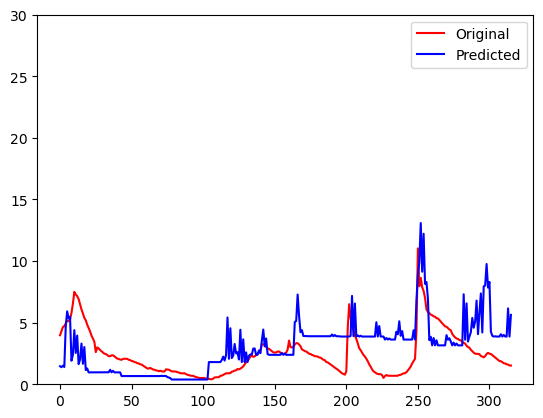

In [21]:
ridge_cv.fit(X_train_scaled,y_train_boxcox)
y_predict = inv_boxcox(ridge_cv.predict(X_test_scaled), lambda_val)

r2 = r2_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)

print("R-squared (R2):", r2)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))

plt.plot(y_test, 'r', label='Original')
plt.plot(y_predict, 'b', label='Predicted')
ax = plt.gca()
ax.set_ylim([0, 30])
plt.legend()
plt.show()